# Get time-mean cold point temperatures

* Make and save netcdfs of climatological/time-mean cold point temperature at each point in space
* Save the mean cold points (time AND space mean) to dictionaries

Using the 0.25° file, not the regridded one!

In [1]:
import pickle
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import regrid_data_cp as rdc

from dask.diagnostics import ProgressBar


In [2]:
file_path = "/work/bb1153/b380887/big_obs_climo/"
pickle_path = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_mean_cpT/"


In [4]:
season = "JJA"

In [5]:
if season == "DJF":
    region_list = ["AMZ", "SPC", "ECP", "IOS"]
    year_list = [2007, 2008, 2009, 2010]
    offset_dict = {
        "AMZ": 9,
        "SPC": 10,
        "IOS": 10,
        "ECP": 9
    }

elif season == "JJA":
    region_list = ["AFR", "ECP", "WPC", "IOE"]
    year_list = [2007, 2008, 2009, 2010] # TODO: add 2006 when done
    offset_dict = {
        "AFR": 10,
        "WPC": 11,
        "IOE": 8,
        "ECP": 8
    }

years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


In [6]:
def get_era5(season, year, region, file_path):
    """ Read in ERA5 12-20 km temperature and total-column geopotential height files
    """
    temp_era5 = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["t"]
    z_era5 = xr.open_dataset(file_path + "{s}/ERA5_zg_0.25deg_ml_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["z"].sortby("time")#/9.81

    # convert longitude from 0-360 to -180-180 if needed (on ERA5 height; changed in z computation)
    if (z_era5.longitude.min() > 180) or (z_era5.longitude.max() > 180):
        z_era5.coords['longitude'] = (z_era5.coords['longitude'] + 180) % 360 - 180
    
    # if one is -180 and the other is 180 at some point:
    if not (np.array_equal(temp_era5.longitude.values, z_era5.longitude.values)):
        inds_diff = np.where((temp_era5.longitude.values - z_era5.longitude.values) > 0)[0]
        if len(inds_diff) > 1:
            raise Exception("ERA5 longitude values are different for temperature & height!")
        else:
            ind = inds_diff[0]
            if abs(temp_era5.longitude.values[ind]) == 180 and abs(z_era5.longitude.values[ind]) == 180:
                new_lon = z_era5.longitude.values
                new_lon[ind] = temp_era5.longitude[ind]
                z_era5 = z_era5.assign_coords({"longitude": new_lon})
                assert(np.array_equal(temp_era5.longitude.values, z_era5.longitude.values))
            else:
                raise Exception("ERA5 longitude values are different for temperature & height!")

        
    # flip the ERA5 coordinates to be increasing if they're not
    if temp_era5.latitude[0] > temp_era5.latitude[-1]:
        temp_era5 = temp_era5.isel(latitude=slice(None, None, -1))
    if temp_era5.longitude[0] > temp_era5.longitude[-1]:
        temp_era5 = temp_era5.isel(longitude=slice(None, None, -1))
    if z_era5.latitude[0] > z_era5.latitude[-1]:
        z_era5 = z_era5.isel(latitude=slice(None, None, -1))
    if z_era5.longitude[0] > z_era5.longitude[-1]:
        z_era5 = z_era5.isel(longitude=slice(None, None, -1))
        
    return temp_era5, z_era5


In [8]:
def cold_point_temp_height(temp, z, div_by_g=True):
    """ Return data array of the cold point temperature & height
    """
    cpT_inds_chunked = temp.chunk("auto").argmin(dim="level")
    # with ProgressBar():
    cpT_inds = cpT_inds_chunked.compute()
    cpT = temp.isel(level=cpT_inds)
    cpz = z.sel(level=temp.level).isel(level=cpT_inds)
    
    if div_by_g:
        cpz = cpz/9.81
    
    return cpT, cpz


Takes ~11 min for DJF

In [9]:
%%time
cpT_dict = {}
cpz_dict = {}

for region in region_list:
    cpT_list = [[]]*len(year_list)
    cpz_list = [[]]*len(year_list)

    for i, year in enumerate(year_list):
        if region == "SPC":
            temp_1, z_1 = get_era5(season, year, "SPC1", file_path)
            temp_2, z_2 = get_era5(season, year, "SPC2", file_path)
            cpT_1, cpz_1 = cold_point_temp_height(temp_1, z_1, div_by_g=True)
            cpT_2, cpz_2 = cold_point_temp_height(temp_2, z_2, div_by_g=True)
            cpT = xr.concat([cpT_1, cpT_2], dim="longitude")#.isel(longitude=0)
            cpz = xr.concat([cpz_1, cpz_2], dim="longitude")#.isel(longitude=0)
        else:
            temp_era5, z_era5 = get_era5(season, year, region, file_path)
            cpT, cpz = cold_point_temp_height(temp_era5, z_era5, div_by_g=True)

        cpT_list[i] = cpT
        cpz_list[i] = cpz

    cpT_dict[region] = xr.concat(cpT_list, dim="time").mean(dim="time")
    cpz_dict[region] = xr.concat(cpz_list, dim="time").mean(dim="time")
    print(region + " done")


AFR done
ECP done
WPC done
IOE done
CPU times: user 5min, sys: 3min 16s, total: 8min 16s
Wall time: 9min 17s


### Get the time- and area-mean value and make spatial plots of time-means

In [10]:
tlims = (187, 197)
zlims = (16, 18)

AMZ 191.31102


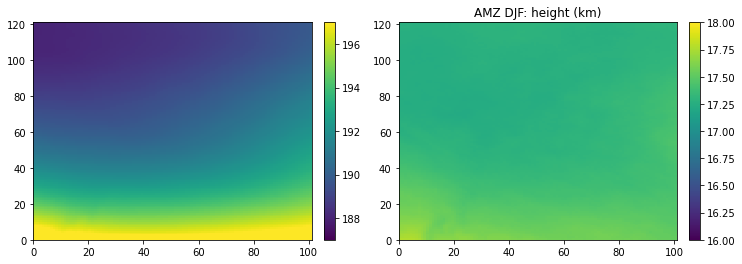

SPC 189.54561


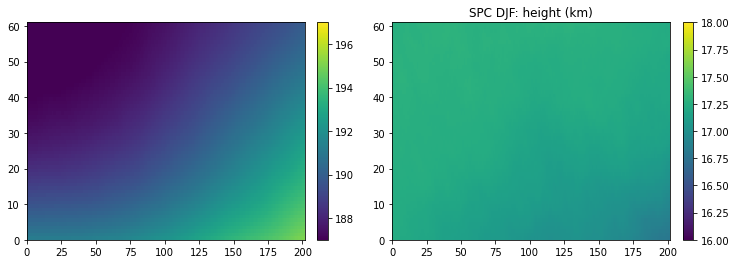

ECP 191.18074


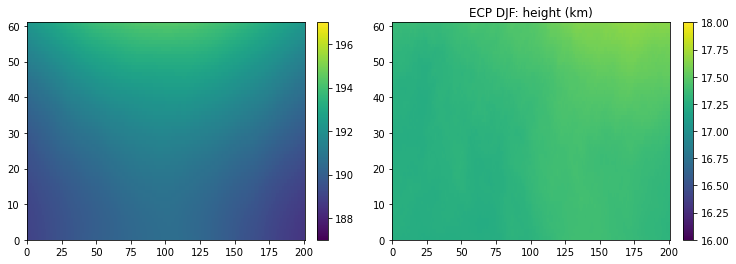

IOS 189.66597


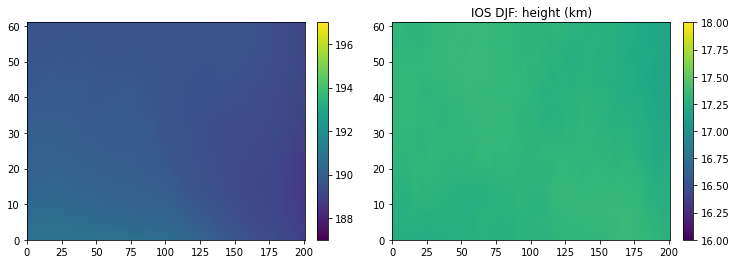

In [30]:
# DJF

cpT_avg_dict = {}

for region in region_list:
    cpT_tavg = cpT_dict[region]
    cpz_tavg = cpz_dict[region]
    cpT_avg_dict[region] = cpT_tavg.mean().values
    print(region, cpT_avg_dict[region])
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    pcm1 = ax1.pcolormesh(cpT_tavg, vmin=tlims[0], vmax=tlims[1])
    cb1 = plt.colorbar(pcm1, ax=ax1, fraction=0.046, pad=0.04)
    ax2.set_title(region + " " + season + ": temperature (K)")

    pcm2 = ax2.pcolormesh(cpz_tavg/1000., vmin=zlims[0], vmax=zlims[1])
    cb2 = plt.colorbar(pcm2, ax=ax2, fraction=0.046, pad=0.04, cmap="viridis_r")
    ax2.set_title(region + " " + season + ": height (km)")
    
    plt.show()


AFR 193.86739


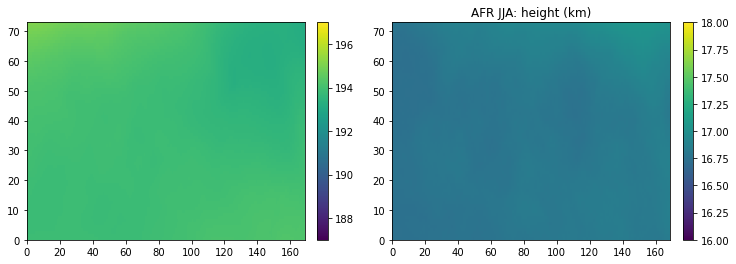

ECP 194.12164


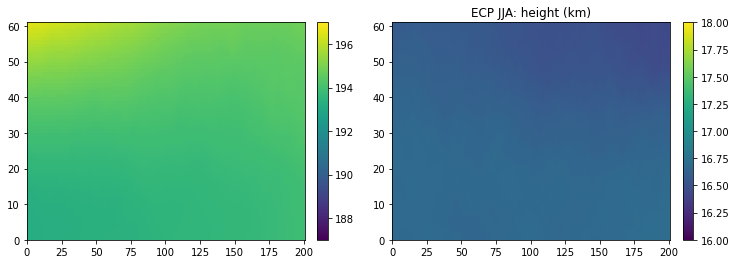

WPC 193.22621


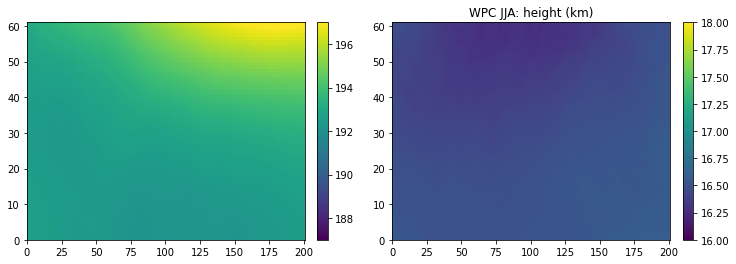

IOE 194.27351


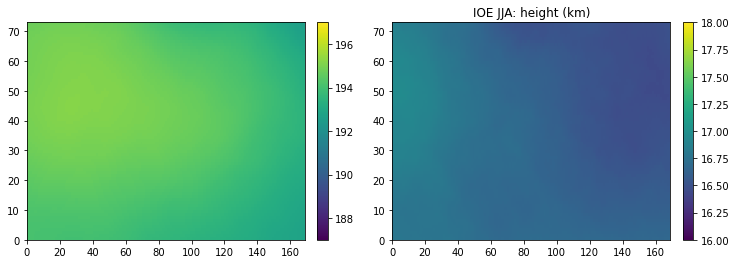

In [11]:
# JJA

cpT_avg_dict = {}

for region in region_list:
    cpT_tavg = cpT_dict[region]
    cpz_tavg = cpz_dict[region]
    cpT_avg_dict[region] = cpT_tavg.mean().values
    print(region, cpT_avg_dict[region])
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    pcm1 = ax1.pcolormesh(cpT_tavg, vmin=tlims[0], vmax=tlims[1])
    cb1 = plt.colorbar(pcm1, ax=ax1, fraction=0.046, pad=0.04)
    ax2.set_title(region + " " + season + ": temperature (K)")

    pcm2 = ax2.pcolormesh(cpz_tavg/1000., vmin=zlims[0], vmax=zlims[1])
    cb2 = plt.colorbar(pcm2, ax=ax2, fraction=0.046, pad=0.04, cmap="viridis_r")
    ax2.set_title(region + " " + season + ": height (km)")
    
    plt.show()


### Save as netcdfs!
One file per region/season with **cold point temperature** and **height** and **overshooting convection threshold** (cpT + offset); also time/area-mean cold point temperature and temperature offset (for the threshold) as attributes

In [12]:
for region in region_list:
    cpT_tavg = cpT_dict[region]
    cpz_tavg = cpz_dict[region]
    cpT_avg = cpT_avg_dict[region]
    offset = offset_dict[region]
    threshold = cpT_tavg + offset
    
    ds = xr.Dataset({"cpT": cpT_tavg, "cpz": cpz_tavg, "os_threshold": threshold},
                    attrs={
                        "temp_offset": offset,
                        "cpT_avg": cpT_avg
                    })
    out_file = file_path + "{s}/ERA5_0.25deg_cp_thresh_{s}{y}_{r}.nc".format(s=season, y=years_str, r=region)
    ds.to_netcdf(out_file)
    